In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [46]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        for i in range(linear_layers - 1):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(linear)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data = self.convex[i*2].weight.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data = self.linear[i*2].weight.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        if not x.requires_grad:
            x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad.detach()

In [40]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], clamp_weights=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

        self.clamp_weights = clamp_weights

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential
        Y_omega = self.to_omega(Y)
        grad_psi_omega = self.psi_omega.gradient(Y_omega)

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * Y_omega, dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, Y):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2]
        """
        # Forward: omega -> theta
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y)
        cycle_loss = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))

        return cycle_loss # THETA

    def compute_loss(self, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        # Step 2: Compute correlations
        loss_corr = self.compute_correlations(X, Y)

        # Step 3: Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(Y)

        # Step 4: Total loss
        loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle

        # Step 5: Gradient step
        loss_total.backward()

        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.psi_theta.update_weights()
            self.psi_omega.update_weights()

        return {
            'loss_corr': loss_corr.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item()
        }

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad(): # we need grad here
        return self.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad(): # we need grad here
        return self.psi_omega.gradient(Y)

In [43]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3):
        self.loss_c = loss_c
        self.optimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()) +
           list(self.loss_c.psi_omega.parameters()),
           lr=lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': []}

    def step(self, X, Y):
        self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(X, Y)
        self.optimizer.step()

        for x in losses.keys():
            self.history[x].append(losses[x])

        return losses

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

Using Colab cache for faster access to the 'summer2winter-yosemite' dataset.


In [13]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_A, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val
        if is_A:
            self.train = "trainA"
            self.test = "testA"
        else:
            self.train = "trainB"
            self.test = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.images = os.listdir(os.path.join(root, self.train))
        else:
            self.images = os.listdir(os.path.join(root, self.test))

        self.pics = len(self.images)

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dir):
        img_path = os.path.join(self.root, pic_dir, self.images[idx])

        # Load the image
        img = Image.open(img_path).resize((self.target_shape, self.target_shape))

        return np.asarray(img, dtype=np.float32), {}

    def get_train(self, idx):
        return self.get(idx, self.train)

    def get_val(self, idx):
        return self.get(idx, self.test)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [71]:
batch_size = 8
datasetA = S2WDataset(path, 128, is_A=True)
datasetB = S2WDataset(path, 128, is_A=False)
pics = min(len(datasetA), len(datasetB))
datasetA.pics = pics
datasetB.pics = pics

datasetVal = S2WDataset(path, 128, is_A=True, is_val=True)

dataloaderA = torch.utils.data.DataLoader(
    datasetA,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataloaderB = torch.utils.data.DataLoader(
    datasetB,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [100]:
# Initialize classes
psi_theta = ConvICNN()
psi_omega = ConvICNN()
loss_c = W2GNLoss(psi_theta, psi_omega)
trainer = W2GNTrainer(loss_c)

# Training loop
epochs = 30

for epoch in range(epochs):
    A_iter = iter(dataloaderA)
    B_iter = iter(dataloaderA)
    Val_iter = iter(dataVal)

    for i in tqdm(range(len(dataloaderA)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X = next(A_iter)[0].permute(0, 3, 1, 2)
        Y = next(B_iter)[0].permute(0, 3, 1, 2)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        print(f"\nEpoch {epoch}: " +
            f"Corr={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Total={losses['loss_total']:.4f}")

    X_test = next(Val_iter)[0].permute(0, 3, 1, 2).to(trainer.loss_c.theta_device())
    Y_generated = trainer.generate(X_test).cpu()

    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')

    for i in range(batch_size):
        X_img = np.asarray(X_test.cpu().permute(0, 2, 3, 1)[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)

        Y_img = np.asarray(Y_generated.cpu().permute(0, 2, 3, 1)[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)

    #plt.tight_layout()
    fig.show()

Epoch 1/30:   1%|          | 1/121 [00:00<01:29,  1.35it/s]


Epoch 0: Corr=1044.2490, Cycle=674573504.0000, Total=337287808.0000


Epoch 1/30:   2%|▏         | 2/121 [00:01<01:21,  1.46it/s]


Epoch 0: Corr=-1903796224.0000, Cycle=202988519424.0000, Total=99590463488.0000


Epoch 1/30:   2%|▏         | 3/121 [00:02<01:18,  1.50it/s]


Epoch 0: Corr=-191198511104.0000, Cycle=633319100252160.0000, Total=316468356972544.0000


Epoch 1/30:   3%|▎         | 4/121 [00:02<01:16,  1.52it/s]


Epoch 0: Corr=-2591470649344.0000, Cycle=104094768711073792.0000, Total=52044794490257408.0000


Epoch 1/30:   4%|▍         | 5/121 [00:03<01:15,  1.53it/s]


Epoch 0: Corr=-14974030184448.0000, Cycle=7117813866733502464.0000, Total=3558892089959776256.0000


Epoch 1/30:   5%|▍         | 6/121 [00:03<01:14,  1.54it/s]


Epoch 0: Corr=-150052467113984.0000, Cycle=285432163039486935040.0000, Total=142715931986162089984.0000


Epoch 1/30:   6%|▌         | 7/121 [00:04<01:14,  1.54it/s]


Epoch 0: Corr=-438814325604352.0000, Cycle=4269206407064278007808.0000, Total=2134602781319673937920.0000


Epoch 1/30:   7%|▋         | 8/121 [00:05<01:13,  1.54it/s]


Epoch 0: Corr=-3214604779913216.0000, Cycle=99203527180663356653568.0000, Total=49601759086732050956288.0000


Epoch 1/30:   7%|▋         | 9/121 [00:05<01:12,  1.54it/s]


Epoch 0: Corr=-7362114037481472.0000, Cycle=860965174382622054285312.0000, Total=430482587191311027142656.0000


Epoch 1/30:   8%|▊         | 10/121 [00:06<01:11,  1.54it/s]


Epoch 0: Corr=-7286809302138880.0000, Cycle=6627038348879588388503552.0000, Total=3313519174439794194251776.0000


Epoch 1/30:   9%|▉         | 11/121 [00:07<01:11,  1.54it/s]


Epoch 0: Corr=-98478420366721024.0000, Cycle=110566279096441047571496960.0000, Total=55283139548220523785748480.0000


Epoch 1/30:  10%|▉         | 12/121 [00:07<01:10,  1.54it/s]


Epoch 0: Corr=-159186949872025600.0000, Cycle=532575763684627727610019840.0000, Total=266287881842313863805009920.0000


Epoch 1/30:  11%|█         | 13/121 [00:08<01:10,  1.54it/s]


Epoch 0: Corr=-610409823078449152.0000, Cycle=4593073401230967556095868928.0000, Total=2296536700615483778047934464.0000


Epoch 1/30:  12%|█▏        | 14/121 [00:09<01:09,  1.54it/s]


Epoch 0: Corr=-345810288269852672.0000, Cycle=22083556561329537136197632000.0000, Total=11041778280664768568098816000.0000


Epoch 1/30:  12%|█▏        | 15/121 [00:09<01:08,  1.54it/s]


Epoch 0: Corr=-3026872773017337856.0000, Cycle=142041898594386904085254111232.0000, Total=71020949297193452042627055616.0000


Epoch 1/30:  13%|█▎        | 16/121 [00:10<01:08,  1.54it/s]


Epoch 0: Corr=-9616944423040450560.0000, Cycle=860391372451775694923534172160.0000, Total=430195686225887847461767086080.0000


Epoch 1/30:  14%|█▍        | 17/121 [00:11<01:07,  1.54it/s]


Epoch 0: Corr=-20988872131732307968.0000, Cycle=4347733367323632489718184148992.0000, Total=2173866683661816244859092074496.0000


Epoch 1/30:  15%|█▍        | 18/121 [00:11<01:07,  1.54it/s]


Epoch 0: Corr=-19871036043167793152.0000, Cycle=14088539822072918193428068564992.0000, Total=7044269911036459096714034282496.0000


Epoch 1/30:  16%|█▌        | 19/121 [00:12<01:06,  1.54it/s]


Epoch 0: Corr=-72729514389754871808.0000, Cycle=80980307061664604241612599459840.0000, Total=40490153530832302120806299729920.0000


Epoch 1/30:  17%|█▋        | 20/121 [00:13<01:05,  1.54it/s]


Epoch 0: Corr=-203926368827056586752.0000, Cycle=431651354711980187162002673631232.0000, Total=215825677355990093581001336815616.0000


Epoch 1/30:  17%|█▋        | 21/121 [00:13<01:05,  1.53it/s]


Epoch 0: Corr=-403444346937615056896.0000, Cycle=1496489696705318550868112089022464.0000, Total=748244848352659275434056044511232.0000


Epoch 1/30:  18%|█▊        | 22/121 [00:14<01:04,  1.53it/s]


Epoch 0: Corr=-290162490760597864448.0000, Cycle=4102855154601964429887171450634240.0000, Total=2051427577300982214943585725317120.0000


Epoch 1/30:  19%|█▉        | 23/121 [00:15<01:03,  1.53it/s]


Epoch 0: Corr=-771788342066946244608.0000, Cycle=16373483945903957241024402140692480.0000, Total=8186741972951978620512201070346240.0000


KeyboardInterrupt: 

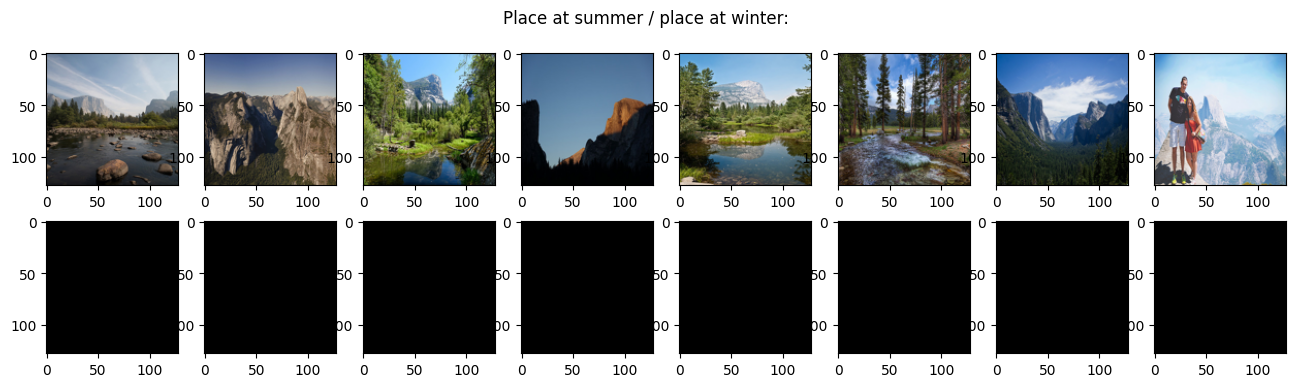

In [101]:
X_test = next(Val_iter)[0].permute(0, 3, 1, 2).to(trainer.loss_c.theta_device())
Y_generated = trainer.generate(X_test).cpu()

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(batch_size):
    X_img = np.asarray(X_test.cpu().permute(0, 2, 3, 1)[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(Y_generated.cpu().permute(0, 2, 3, 1)[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()